In [97]:
%reload_ext autoreload
%autoreload 2
import morph_mm.models.transformer as transformer
from morph_mm.models.img_bert import ImgBERT
from morph_mm.utils import SinCos2DPosEmbed, Learned2DPosEmbed
from morph_mm.dataset.mnist import get_mnist_dataset
from morph_mm.lightning.lit_model import LitImgBert

import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import lightning as L
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger

from configs import config_imgbert_mnist

In [79]:
cfg = config_imgbert_mnist.get_train_cfg()
cfg.model.mask_ratio = 0.8
cfg.model.encoder.num_layers = 8
cfg.model.decoder.mlp_num_inner_layers = 2
cfg

data:
  img_size: 28
  in_channels: 1
  patch_size: 4
loss: l2
model:
  decoder:
    mlp_inner_dim: 64
    mlp_num_inner_layers: 2
    pos_embed: sine_cos
  encoder:
    mlp_inner_dim: 64
    model_dim: 32
    num_heads: 4
    num_layers: 8
    pos_embed: sine_cos
  mask_ratio: 0.8

In [43]:
x = torch.tensor(np.random.randn(8, 16, 32), dtype=torch.float)
x.shape

torch.Size([8, 16, 32])

In [30]:
tmp = transformer.Transformer(config)
out = tmp(x)
print(out.shape)

torch.Size([8, 16, 32])


In [39]:
x = torch.tensor(np.random.randn(1, 32), dtype=torch.float)
x = x[None, :, :].expand(-1, 5, -1)
x.shape

torch.Size([1, 5, 32])

In [60]:
x = torch.tensor(np.random.rand(1, 5, 128, 128), dtype=torch.float)
tmp = ImgBERT(cfg)
pred, take = tmp({'img':x})
take.shape

torch.Size([1, 4, 32])

In [52]:
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
train_mnist = torchvision.datasets.MNIST(root='/Users/shiveshchaudhary/Documents/projects/mnist',
                                         train=True,
                                         download=True,
                                         transform=image_transform)
train_mnist_dataloader = torch.utils.data.DataLoader(train_mnist, batch_size=2, shuffle=True)

In [ ]:
x = train_mnist[1][0]
x = x.repeat(3, 1, 1)

nch = x.shape[0]
ps = 7
nx = x.shape[1]//ps
ny = x.shape[2]//ps
x = x[None, :, :, :]
x = torch.reshape(x, (x.shape[0], x.shape[1], nx, ps, ny, ps))
x = torch.permute(x, (0, 2, 4, 1, 3, 5))
x = torch.reshape(x, (x.shape[0], nx, ny, -1))
x = torch.reshape(x, (x.shape[0], -1, x.shape[3]))
x.shape

torch.Size([1, 16, 147])

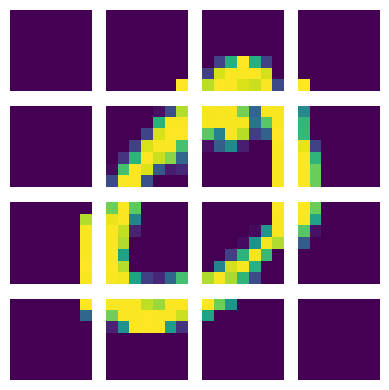

In [143]:
tmp = torch.reshape(x, (x.shape[0], -1, nch, ps, ps))
fig, ax = plt.subplots(4, 4, figsize=(4, 4))
for i in range(x.shape[1]):
    s_row = i//4
    s_col = i%4
    ax[s_row, s_col].imshow(tmp[0, i, 0])
    ax[s_row, s_col].axis('off')
fig.tight_layout()

In [144]:
x = torch.reshape(x, (x.shape[0], nx, ny, nch, ps, ps))
x = torch.permute(x, (0, 3, 1, 4, 2, 5))
x = torch.reshape(x, (x.shape[0], x.shape[1], nx*ps, ny*ps))
x.shape

torch.Size([1, 3, 28, 28])

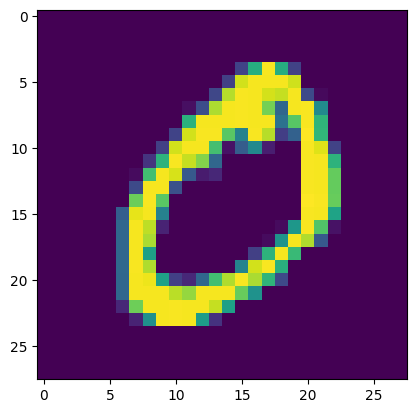

In [145]:
plt.imshow(x[0, 0])

In [84]:
x = torch.tensor(np.arange(1, 21))
x = torch.reshape(x, (5, -1))
x = x[None, :, :]
x = x.repeat(2, 1, 1)

mask_param = torch.tensor(np.random.rand(x.shape[0], x.shape[1]))
idx = torch.argsort(mask_param, dim=1)
restore_idx = torch.argsort(idx, dim=1)

In [107]:
idx

tensor([[4, 3, 0, 2, 1],
        [0, 1, 3, 4, 2]])

In [106]:
restore_idx

tensor([[2, 4, 3, 1, 0],
        [0, 1, 4, 2, 3]])

In [102]:
idx.shape

torch.Size([2, 5])

In [105]:
idx[:, :, None].repeat(1, 1, x.shape[2])

tensor([[[4, 4, 4, 4],
         [3, 3, 3, 3],
         [0, 0, 0, 0],
         [2, 2, 2, 2],
         [1, 1, 1, 1]],

        [[0, 0, 0, 0],
         [1, 1, 1, 1],
         [3, 3, 3, 3],
         [4, 4, 4, 4],
         [2, 2, 2, 2]]])

In [113]:
mask_token = torch.zeros((1, 1, 4))
y = torch.gather(x, dim=1, index=idx[:, :, None].repeat(1, 1, x.shape[2]))
take = y[:, 0:2, :]
keep = y[:, 2::, :]
y = torch.concat([mask_token.repeat(y.shape[0], 2, 1), keep], dim=1)
y = torch.gather(y, dim=1, index=restore_idx[:, :, None].repeat(1, 1, x.shape[2]))
y

tensor([[[ 1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.],
         [ 9., 10., 11., 12.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 9., 10., 11., 12.],
         [13., 14., 15., 16.],
         [17., 18., 19., 20.]]])

In [ ]:
cfg = config_imgbert_mnist.get_train_cfg()
cfg.data.img_size = 28
cfg.data.in_channels = 3
cfg.data.patch_size = 14
cfg

data:
  img_size: 28
  in_channels: 3
  patch_size: 14
model:
  decoder:
    mlp_inner_dim: 64
    mlp_num_inner_layers: 1
  encoder:
    mlp_inner_dim: 64
    model_dim: 32
    num_heads: 4
    num_layers: 3
  mask_ratio: 0.25

In [53]:
x = next(iter(train_mnist_dataloader))
print(x[0].shape)
print(x[1])

torch.Size([2, 1, 28, 28])
tensor([3, 3])


In [60]:
model = ImgBERT(cfg)
inp = x[0].repeat(1, 3, 1, 1)
pred, gt, cls_token = model({'img':inp})

AttributeError: "'pos_embed'"

In [55]:
tmp = torch.reshape(gt, (gt.shape[0], gt.shape[1], 3, 14, 14))
tmp.shape

torch.Size([2, 1, 3, 14, 14])

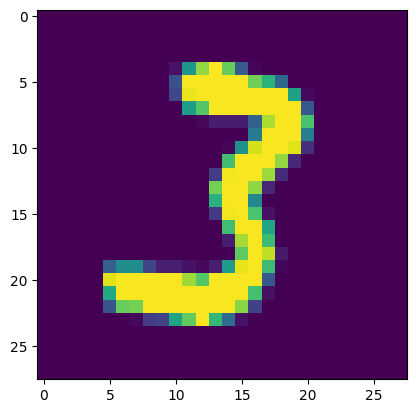

In [58]:
plt.imshow(inp[1, 0])

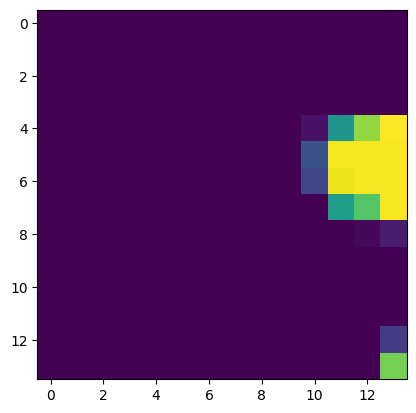

In [59]:
plt.imshow(tmp[1, 0, 2])

In [64]:
emb = Learned2DPosEmbed(32, 4, 4)

In [68]:
freq = np.linspace(0, 2*np.pi, 32)

In [71]:
torch.tensor(freq)

tensor([0.0000, 0.2027, 0.4054, 0.6081, 0.8107, 1.0134, 1.2161, 1.4188, 1.6215,
        1.8242, 2.0268, 2.2295, 2.4322, 2.6349, 2.8376, 3.0403, 3.2429, 3.4456,
        3.6483, 3.8510, 4.0537, 4.2564, 4.4590, 4.6617, 4.8644, 5.0671, 5.2698,
        5.4725, 5.6751, 5.8778, 6.0805, 6.2832], dtype=torch.float64)

In [85]:
emb = SinCos2DPosEmbed(32, 4, 4)
emb().shape

torch.Size([16, 64])

In [38]:
model = ImgBERT(cfg)

In [80]:
train_data, test_data = get_mnist_dataset()
train_data = torch.utils.data.Subset(train_data, np.arange(0, 2))
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=True)
lit_model = LitImgBert(cfg)

In [81]:
batch = next(iter(train_dataloader))
batch['img'].shape
batch['label']

tensor([0, 5])

In [39]:
pred, gt, cls_token, orig_img, recon_img = model(batch)

In [117]:
cls_token.shape

torch.Size([2, 32])

In [98]:
logger = TensorBoardLogger(
    save_dir='/Users/shiveshchaudhary/Documents/projects/morph_vilbert/ckpts/mnist_imgbert/lightning_logs',
    name='',
    version='7',  # force re-use of version_7
)

trainer = L.Trainer(max_epochs=2000,
                    accelerator='cpu',
                    logger=logger,
                    )

trainer.fit(model=lit_model,
            train_dataloaders=train_dataloader,
            ckpt_path='/Users/shiveshchaudhary/Documents/projects/morph_vilbert/ckpts/mnist_imgbert/lightning_logs/version_7/checkpoints/epoch=999-step=1000.ckpt')

ModuleNotFoundError: Neither `tensorboard` nor `tensorboardX` is available. Try `pip install`ing either.
Requirement 'tensorboardX' not met. HINT: Try running `pip install -U 'tensorboardX'`
Requirement 'tensorboard' not met. HINT: Try running `pip install -U 'tensorboard'`

In [83]:
model = LitImgBert.load_from_checkpoint(
    '/Users/shiveshchaudhary/Documents/projects/morph_vilbert/ckpts/mnist_imgbert/lightning_logs/version_6/checkpoints/epoch=999-step=1000.ckpt',
    config=cfg)
model.eval()

LitImgBert(
  (model): ImgBERT(
    (pos_embed): SinCos2DPosEmbed()
    (proj): Linear(in_features=16, out_features=32, bias=True)
    (encoder): Transformer(
      (encoder): Sequential(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
          )
          (linear1): Linear(in_features=32, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=64, out_features=32, bias=True)
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=

In [84]:
pred, gt, cls_token, orig_img, recon_img = model(batch)

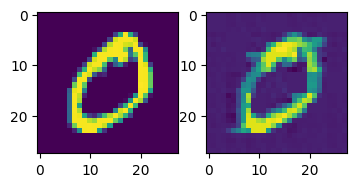

In [86]:
idx = 0
fig, ax = plt.subplots(1, 2, figsize=(4, 8))
ax[0].imshow(orig_img.detach()[idx, 0])
ax[1].imshow(recon_img.detach()[idx, 0])